In [1]:
from sentinelhub import SHConfig, BBox, CRS, DataCollection, bbox_to_dimensions, SentinelHubRequest, MimeType
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from IPython.display import Image
import cv2
import numpy as np
import requests
import json

In [22]:
def fetch_latest_delivery(access_token, subscription_id):
    url = f"https://services.sentinel-hub.com/api/v1/dataimport/subscriptions/{subscription_id}/deliveries"
    headers = {
        'Authorization': f'Bearer {access_token}'
    }

    # Fetch the list of deliveries for the subscription
    response = requests.get(url, headers=headers)
    if response.ok:
        deliveries = response.json()

        # Assuming the deliveries are sorted by date, or you can sort them
        latest_delivery = deliveries[0]  # Assuming the first one is the latest

        return latest_delivery
    else:
        raise Exception(f"Error fetching deliveries: {response.text}")


def fetch_latest_image(access_token, subscription_id):
    latest_delivery = fetch_latest_delivery(access_token, subscription_id)
    delivery_id = latest_delivery['id']

    url = f"https://services.sentinel-hub.com/api/v1/dataimport/subscriptions/{subscription_id}/deliveries/{delivery_id}/files"
    headers = {
        'Authorization': f'Bearer {access_token}'
    }

    response = requests.get(url, headers=headers)
    if response.ok:
        return response.content
    else:
        raise Exception(f"Error retrieving file: {response.text}")

In [ ]:
access_token = 'YOUR_ACCESS_TOKEN'
subscription_id = 'YOUR_SUBSCRIPTION_ID'

image_data = fetch_latest_image(access_token, subscription_id)

In [16]:
img_path = 'seaweed_indo.jpg'
img = cv2.imread(img_path)

# OpenCV reads images in BGR format by default. If your image is in RGB, convert it to BGR
img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

Image Processing

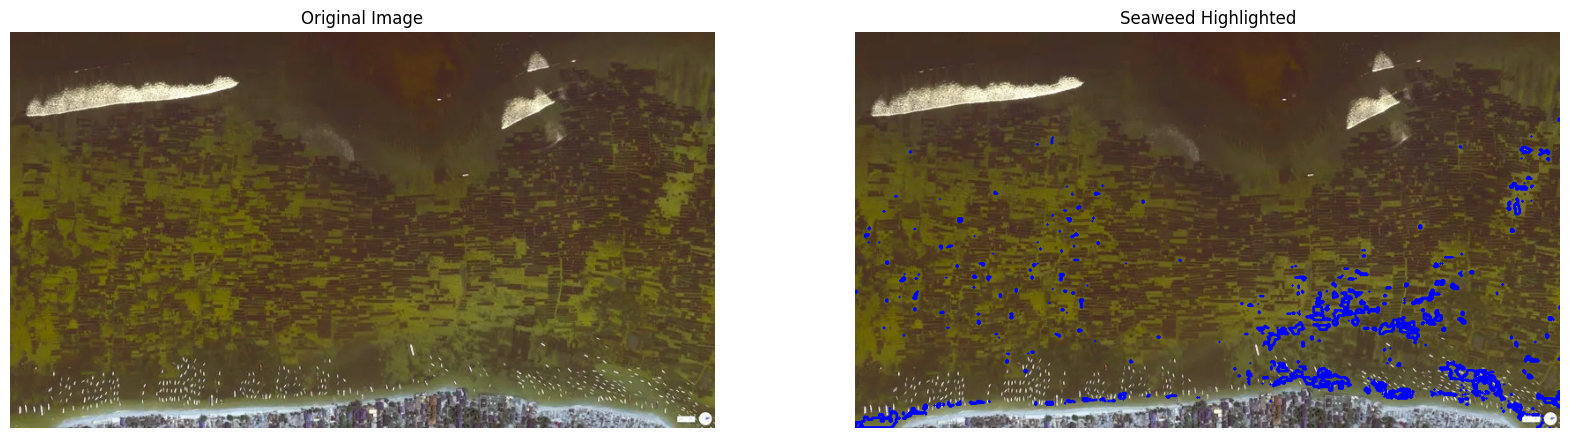

In [20]:
# Convert the image to the HSV color space
hsv_img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

# Define range of color in HSV to identify the seaweed
# These values should be adjusted based on the actual color of the seaweed
lower_val = np.array([30, 100, 50])
upper_val = np.array([85, 255, 255])

# Threshold the HSV image to get only the colors of the seaweed
mask = cv2.inRange(hsv_img, lower_val, upper_val)

# Find contours and highlight the area
contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
highlighted_img = img_bgr.copy()
cv2.drawContours(highlighted_img, contours, -1, (255, 0, 0), 2)

# Display the original and highlighted images using matplotlib
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# Convert BGR images to RGB for displaying correctly in matplotlib
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
highlighted_img_rgb = cv2.cvtColor(highlighted_img, cv2.COLOR_BGR2RGB)

# Display original image
ax[0].imshow(img_rgb)
ax[0].set_title('Original Image')
ax[0].axis('off')

# Display highlighted image
ax[1].imshow(highlighted_img_rgb)
ax[1].set_title('Seaweed Highlighted')
ax[1].axis('off')

plt.show()